# Customize lift charts

Author: Taylor Larkin
Version Date: 2023-01-13

This notebook outlines how to recreate and customize DataRobot's [lift chart](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/lift-chart.html#lift-chart) from a DataRobot blueprint (i.e., a modeling pipeline encompassing the combination of data preprocessing steps and machine learning algorithm). This can be beneficial when:

- More than 60 bins are needed (since 60 is the highest provided out-of-the-box in DataRobot)
- The color scheme needs to be changed from DataRobot's graphical user interface (GUI) default
- Additional information is required to be displayed (e.g., prediction standard deviation in each bin)

While using insights from DataRobot GUI as-is works in many cases, practitioners may need to augment them to better meet technical requirements, formatting guidelines, or other business needs. To do this, leverage DataRobot's [Python client](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html) to extract the predictions in order to manually create our own lift chart visualization. The steps in this notebook are as follows:

1. Setup: import libraries and connect to DataRobot
2. Build a model in manual mode
3. Retrieve predictions and actuals
4. Recreate DataRobot’s lift chart
5. Customize the lift chart

This notebook _should_ work for any regression or binary classification dataset as-is (or with minimal changes). The ideas presented here can be extended to other project types (e.g., multiclass classification), but is not the focus here.

## Setup

First, import the necessary packages and set up the connection to the DataRobot platform.

### Import libraries

In [1]:
import datarobot as dr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datarobot.models.modeljob import wait_for_async_model_creation

print(f"DataRobot version: {dr.__version__}")

DataRobot version: 3.0.2


### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [3]:
DATAROBOT_ENDPOINT="https://app.datarobot.com/api/v2"
# The URL may vary depending on your hosting preference, the above example is for DataRobot Managed AI Cloud

DATAROBOT_API_TOKEN="<INSERT YOUR DataRobot API Token>"
# The API Token can be found by click the avatar icon and then </> Developer Tools

client =dr.Client(
    token=DATAROBOT_API_TOKEN, 
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix='AIA-AE-CLC-51'
)

dr.client._global_client = client

## Create a dataset

Next, [simulate a dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html) to use. There are a variety of ways exist for bringing data into DataRobot, and for this notebook generate the dataset in memory and create a DataRobot project with `dr.Project.create()`. Loading data into memory gives you the ability to easily match your predictions back to the actuals - a necessary step for manually creating the lift chart.

### Define parameters

In [2]:
n_rows = 10000  # Number of rows to generate in dataset
n_columns = 10  # Number of columns to generate in dataset
noise = 1  # Noise to add to target (the larger the value, the harder the problem)
target = "y"  # Target name
binary_target = False  # Assign the target as regression or binary classification

### Simulate data

Simulate data and create a DataFrame.

In [3]:
# Set random seed
generator = np.random.RandomState(10)

X = generator.uniform(size=(n_rows, n_columns))
y = (
    10 * np.sin(np.pi * X[:, 0] * X[:, 1])
    + 20 * (X[:, 2] - 0.5) ** 2
    + 10 * X[:, 3]
    + 5 * X[:, 4]
    + noise * generator.standard_normal(size=(n_rows))
)

# Make into a dataframe
df = pd.DataFrame(X)
df.columns = ["X" + str(x) for x in df.columns + 1]
df[target] = y

# If binary target requested, make regression target dichotomous
if binary_target:

    df[target] = df[target] >= df[target].quantile(0.75)

# Verify
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y
0,0.771321,0.020752,0.633648,0.748804,0.498507,0.224797,0.198063,0.760531,0.169111,0.088340,11.913278
1,0.685360,0.953393,0.003948,0.512192,0.812621,0.612526,0.721755,0.291876,0.917774,0.714576,24.068253
2,0.542544,0.142170,0.373341,0.674134,0.441833,0.434014,0.617767,0.513138,0.650397,0.601039,11.747699
3,0.805223,0.521647,0.908649,0.319236,0.090459,0.300700,0.113984,0.828681,0.046896,0.626287,17.407996
4,0.547586,0.819287,0.198948,0.856850,0.351653,0.754648,0.295962,0.883936,0.325512,0.165016,23.389963
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.542226,0.698229,0.876214,0.327000,0.258875,0.847245,0.916822,0.832540,0.836324,0.985630,15.493394
9996,0.707206,0.844559,0.557480,0.655290,0.998475,0.962390,0.904902,0.600556,0.571323,0.644517,22.044305
9997,0.953571,0.660269,0.366372,0.255462,0.330049,0.405171,0.096756,0.594282,0.741718,0.422292,15.128376
9998,0.550378,0.187699,0.922120,0.034463,0.418147,0.502478,0.465555,0.910769,0.431381,0.424030,10.505233


### Create a project

In [4]:
project = dr.Project.create(sourcedata=df, project_name="Custom Lift Chart")
project

Project(Custom Lift Chart)

## Modeling

After creating a project, you can initiate modeling in manual mode. As the name implies,"manual mode tells DataRobot to _not_ run any blueprints automatically, leaving it up to you to decide which blueprints you'd like to run. Here, you'll pull the list of blueprints in the repository (i.e., the list of blueprints DataRobot thinks will work well for your dataset), pick just one of them, and train it.

### Initiate Autopilot

In [5]:
# Specify manual mode
mode = dr.enums.AUTOPILOT_MODE.MANUAL

# Run manual mode
project.analyze_and_model(
    target=target,
    mode=mode,
    worker_count=-1,  # Setting the worker count to -1 will ensure that you use the max available workers for your account
    max_wait=600,
)

# Asserting target type is met
assert project.target_type in [
    "Binary",
    "Regression",
], "Project is not a regression or binary classification task!"

### List blueprints

In [6]:
# List potential blueprints
blueprints = project.get_blueprints()
print(f"Number of blueprints available for this dataset: {len(blueprints)}")

# Choose just 1 (the first xgboost blueprint listed)
blueprint = [x for x in blueprints if "eXtreme Gradient Boosted Trees" in x.model_type][
    0
]
blueprint

Number of blueprints available for this dataset: 75


Blueprint(eXtreme Gradient Boosted Trees Regressor with Early Stopping (learning rate =0.01))

In [7]:
# Train the blueprint
model_job_id = project.train(blueprint)

# Wait for it to complete
model = wait_for_async_model_creation(
    project_id=project.id,
    model_job_id=model_job_id,
)
model

Model('eXtreme Gradient Boosted Trees Regressor with Early Stopping (learning rate =0.01)')

Use the following cell to view the model on DataRobot's Leaderboard.

In [ ]:
project.open_in_browser()

### Retrieve predictions

In order to recreate the lift chart, you need both the model predictions and the actuals (i.e., the target's actual values) associated with those predictions. To extract the former, use `datarobot.models.Model.request_training_predictions()` and for the latter, join the actuals for the dataset you have in memory based on the provided "row_id" by DataRobot. For this example, use the holdout partition.

In [9]:
# Allow holdout to be used for analysis
project.unlock_holdout()

# Specify the data partition
data_partition = dr.enums.DATA_SUBSET.HOLDOUT

# Calculate predictions on holdout partition of dataset
training_predictions_job = model.request_training_predictions(data_partition)
training_predictions = training_predictions_job.get_result_when_complete()

# Fetch predictions as a dataframe
holdout_preds = training_predictions.get_all_as_dataframe()
holdout_preds

,row_id,partition_id,prediction
0,0,Holdout,12.333032
1,1,Holdout,22.046879
2,2,Holdout,13.242794
3,5,Holdout,7.475697
4,6,Holdout,16.018303
...,...,...,...
1995,9971,Holdout,10.902606
1996,9973,Holdout,10.663506
1997,9983,Holdout,8.017990
1998,9988,Holdout,16.215534


In [10]:
# Join in the actuals using the "row_id" column
holdout_preds_with_actuals = (
    holdout_preds.set_index("row_id")
    .join(df[target])
    .rename(columns={"prediction": "predicted", target: "actual"})
    .drop("partition_id", axis=1)
    .reset_index()
)
holdout_preds_with_actuals

,row_id,predicted,actual
0,0,12.333032,11.913278
1,1,22.046879,24.068253
2,2,13.242794,11.747699
3,5,7.475697,5.674158
4,6,16.018303,15.532014
...,...,...,...
1995,9971,10.902606,9.173533
1996,9973,10.663506,12.885225
1997,9983,8.017990,8.178589
1998,9988,16.215534,15.902147


In [11]:
# Preprocess the output if you have a binary classification problem
if project.target_type == "Binary":

    # If string, turn target into binary 1/0
    if pd.api.types.is_object_dtype(holdout_preds_with_actuals["actual"]):

        holdout_preds_with_actuals["actual"] = (
            holdout_preds_with_actuals["actual"] == project.positive_class
        ).astype(int)

        holdout_preds_with_actuals["predicted"] = holdout_preds_with_actuals[
            f"class_{project.positive_class}"
        ]

    else:

        # Take the positive class probability predictions only
        holdout_preds_with_actuals["predicted"] = holdout_preds_with_actuals[
            f"class_{float(project.positive_class)}"
        ]

    # Keep only relevant columns
    holdout_preds_with_actuals = holdout_preds_with_actuals[["predicted", "actual"]]

# Check
holdout_preds_with_actuals

,row_id,predicted,actual
0,0,12.333032,11.913278
1,1,22.046879,24.068253
2,2,13.242794,11.747699
3,5,7.475697,5.674158
4,6,16.018303,15.532014
...,...,...,...
1995,9971,10.902606,9.173533
1996,9973,10.663506,12.885225
1997,9983,8.017990,8.178589
1998,9988,16.215534,15.902147


## Recreate DataRobot’s lift chart

Now that you have the necessary data, recreate the lift chart. Note the next cell has some helper functions.

In [12]:
# Increase the font
plt.rcParams.update({"font.size": 12})


def prepare_lift_chart_data(preds: pd.DataFrame, n_bins: int = 10) -> pd.DataFrame:
    """
    This function aggregates data into specified bins for easier plotting.

    Parameters
    ----------
    preds: dataframe consisting of a columns "predicted" and "actual" representing the predicted and target values, respectively
    n_bins: how many groups to use for splitting the data

    Returns
    ----------
    Dataframe containing aggregated data needed to create DataRobot's lift chart
    """

    # First define the bins based on the predictions
    preds = preds.copy()
    preds["bins"] = pd.qcut(
        preds["predicted"], q=n_bins, labels=np.arange(1, n_bins + 1, 1), retbins=False
    ).values

    # Aggregate
    plot_data = (
        preds.groupby("bins")
        .agg(
            actual=("actual", "mean"),
            predicted=("predicted", "mean"),
            bin_weight=("bins", "size"),
            predicted_std=("predicted", "std"),
        )
        .reset_index(drop=True)
    )

    return plot_data


def generate_dr_lift_chart(plot_data: pd.DataFrame, title: str = ""):
    """
    This function creates a lift chart with a similar color scheme as DataRobot's GUI.

    Parameters
    ----------
    plot_data: output of the function "prepare_lift_chart_data()"
    title: what to use for the chart's title
    """

    # Color scheme
    predicted_color = "#1F77B4"
    actual_color = "#FF7F0E"
    background_color = "black"

    # Defining bins
    bin_labels = range(1, plot_data.shape[0] + 1)

    # Initialize
    fig, ax = plt.subplots(figsize=(20, 7))

    # Plots
    ax.plot(
        bin_labels,
        plot_data["actual"],
        lw=2,
        color=actual_color,
        marker="o",
        markersize=8,
        markerfacecolor="none",
        markeredgewidth=2,
        label="Actual",
    )
    ax.plot(
        bin_labels,
        plot_data["predicted"],
        lw=2,
        color=predicted_color,
        marker="+",
        markersize=8,
        markeredgewidth=2,
        label="Predicted",
    )

    # Settings
    ax.set_facecolor(background_color)
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("Bins based on predicted value")
    ax.set_ylabel("Average target value")
    ax.grid(visible=True, color="gray", linewidth=0.25)
    plt.margins(0.025)  # to reduce white space

    # To ensure the xticks aren't too crowded
    if plot_data.shape[0] <= 60:

        plt.xticks(np.arange(1, plot_data.shape[0] + 1, 1))

    plt.title(title)
    plt.show()

In [13]:
# Aggregate the data for plotting
lift_chart_data = prepare_lift_chart_data(preds=holdout_preds_with_actuals, n_bins=60)
lift_chart_data.head()

,actual,predicted,bin_weight,predicted_std
0,3.886306,5.032225,34,0.961431
1,5.138813,6.534360,33,0.285011
2,6.094226,7.425707,33,0.270855
3,7.035252,8.177715,34,0.173467
4,7.494018,8.798627,33,0.109997


In [14]:
# Verify with the data you get from DataRobot
dr_lift_chart_data = pd.DataFrame(model.get_lift_chart(source=data_partition).bins)
dr_lift_chart_data.head()

,actual,predicted,bin_weight
0,3.886306,5.032225,34.0
1,5.138813,6.534360,33.0
2,6.094226,7.425707,33.0
3,7.035252,8.177715,34.0
4,7.494018,8.798627,33.0


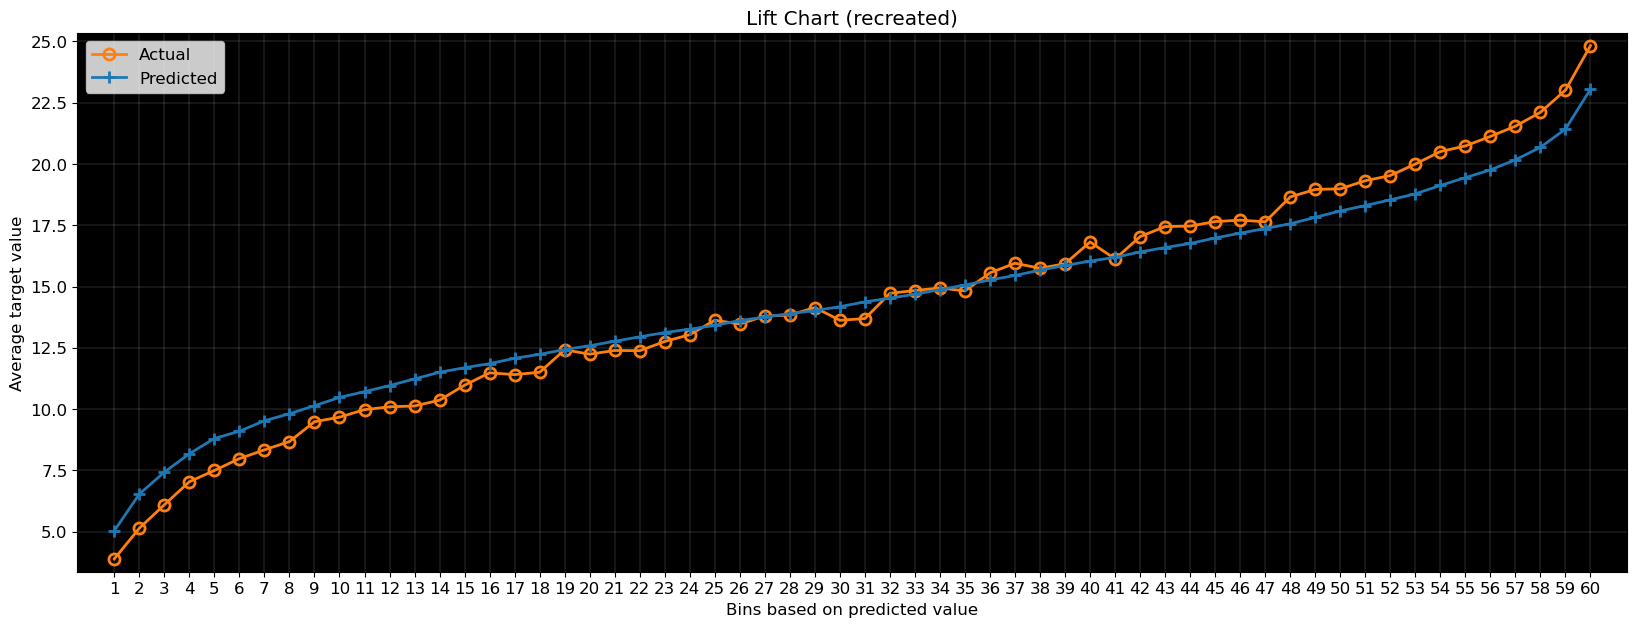

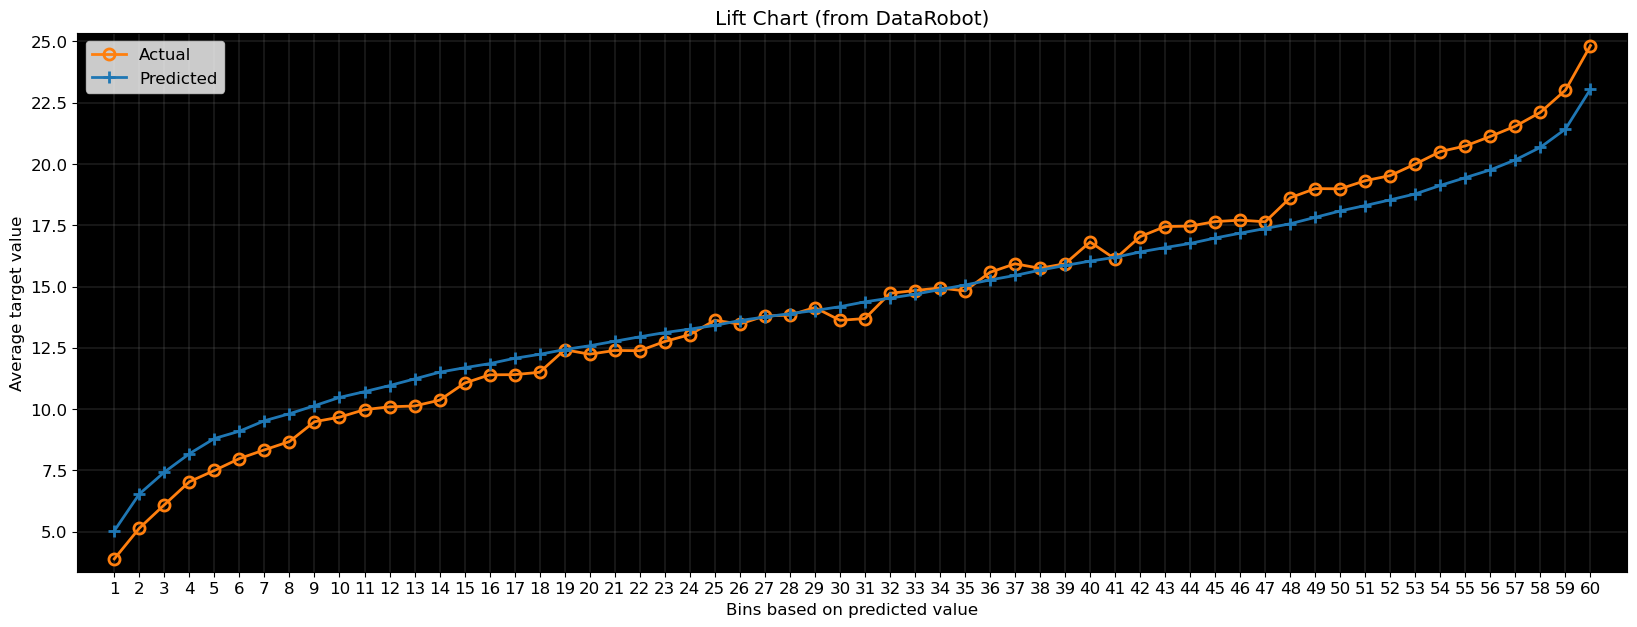

In [15]:
# Plot both and see if they're the similar
generate_dr_lift_chart(plot_data=lift_chart_data, title="Lift Chart (recreated)")
generate_dr_lift_chart(
    plot_data=dr_lift_chart_data, title="Lift Chart (from DataRobot)"
)

### Customize the lift chart

Finally, now that you've seen how to recreate DataRobot lift chart, you can do some customization. This can include augmenting the bin sizes to ones that DataRobot doesn't have by default, changing the color scheme, or plotting additional information (e.g., the standard deviation in each prediction bin). While the next cells focus on these customization topics, they are not an exhaustive list. The beauty of having the ability to easily gather the necessary data gives you the ability to be creative in the way you present our visuals.

In [16]:
def generate_customized_lift_chart(
    plot_data: pd.DataFrame, title: str = "", std_multiplier: int = 1
):
    """
    This function creates a lift chart with a custom color scheme and displays the prediction standard deviation in each bin.

    Parameters
    ----------
    plot_data: output of the function "prepare_lift_chart_data()"
    title: what to use for the chart's title
    std_multipler: how much to multply the standard deviation about the prediction mean
    """

    # Color scheme
    predicted_color = "purple"
    actual_color = "green"
    background_color = "white"

    # Defining bins
    bin_labels = range(1, plot_data.shape[0] + 1)

    # Initialize
    fig, ax = plt.subplots(figsize=(20, 7))

    # Plots
    ax.plot(
        bin_labels,
        plot_data["actual"],
        lw=2,
        color=actual_color,
        marker="o",
        markersize=8,
        markerfacecolor="none",
        markeredgewidth=2,
        label="Actual",
    )
    ax.plot(
        bin_labels,
        plot_data["predicted"],
        lw=2,
        color=predicted_color,
        marker="+",
        markersize=8,
        markeredgewidth=2,
        label="Predicted",
    )

    # Specifying standard deviation boundary
    lower_bound = plot_data["predicted"] - std_multiplier * plot_data["predicted_std"]
    upper_bound = plot_data["predicted"] + std_multiplier * plot_data["predicted_std"]

    # If binary target, clip at [0, 1]
    if plot_data["actual"].between(0, 1).all():

        lower_bound = np.clip(lower_bound, 0, 1)
        upper_bound = np.clip(upper_bound, 0, 1)

    # Shaded region for standard deviation
    ax.fill_between(
        bin_labels,
        lower_bound,
        upper_bound,
        alpha=0.3,
        color=predicted_color,
    )

    # Settings
    ax.set_facecolor(background_color)
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel("Bins based on predicted value")
    ax.set_ylabel("Average target value")
    ax.grid(visible=True, color="black", linewidth=0.25)
    plt.margins(0.025)  # to reduce white space

    # To ensure the xticks aren't too crowded
    if plot_data.shape[0] <= 60:

        plt.xticks(np.arange(1, plot_data.shape[0] + 1, 1))

    plt.title(title)
    plt.show()

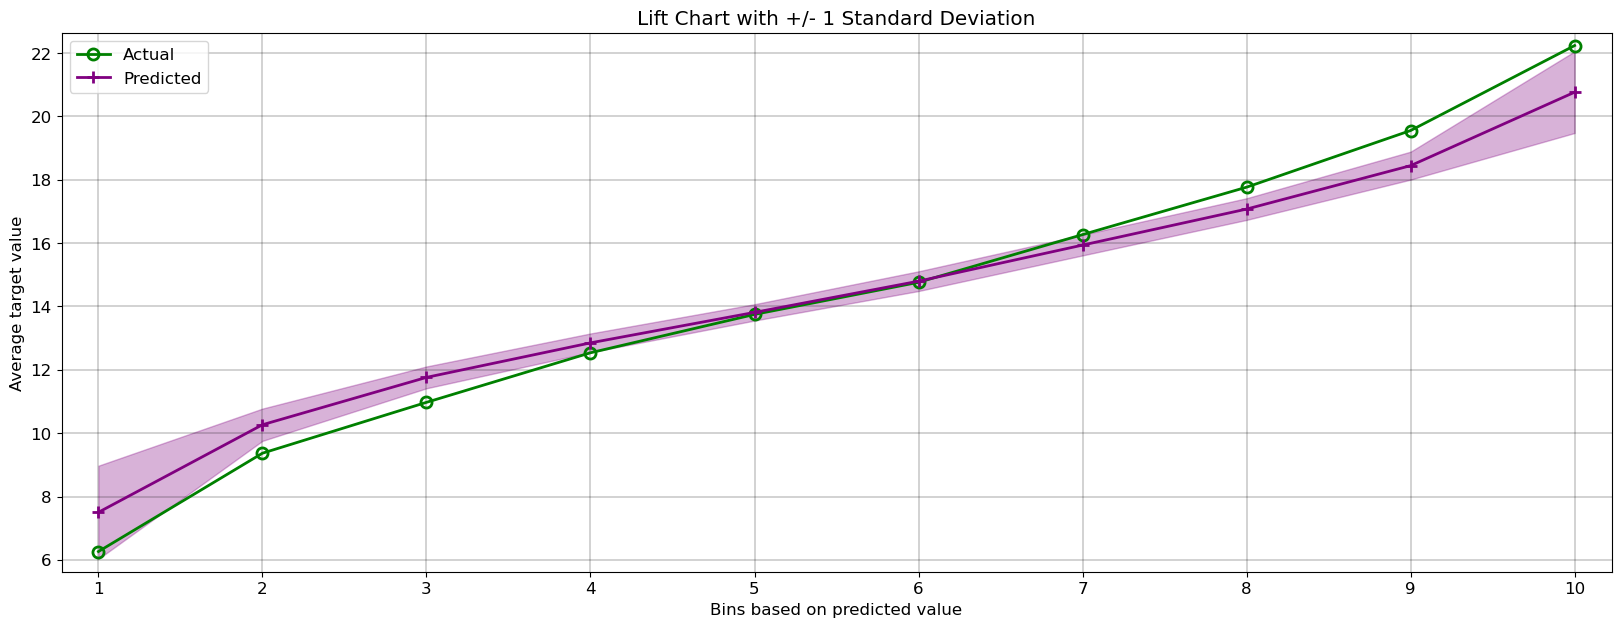

In [17]:
# Plot it
lift_chart_data = prepare_lift_chart_data(preds=holdout_preds_with_actuals, n_bins=10)
generate_customized_lift_chart(
    plot_data=lift_chart_data, title=f"Lift Chart with +/- 1 Standard Deviation"
)

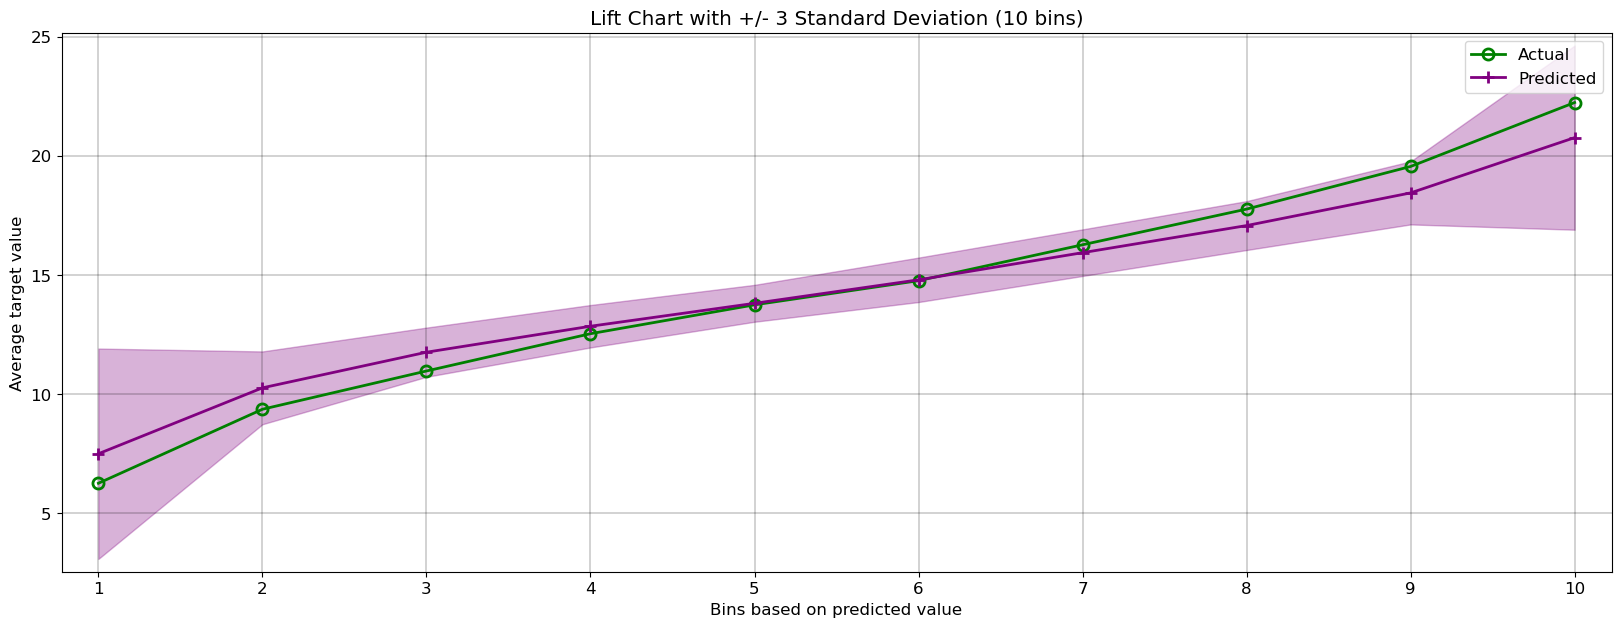

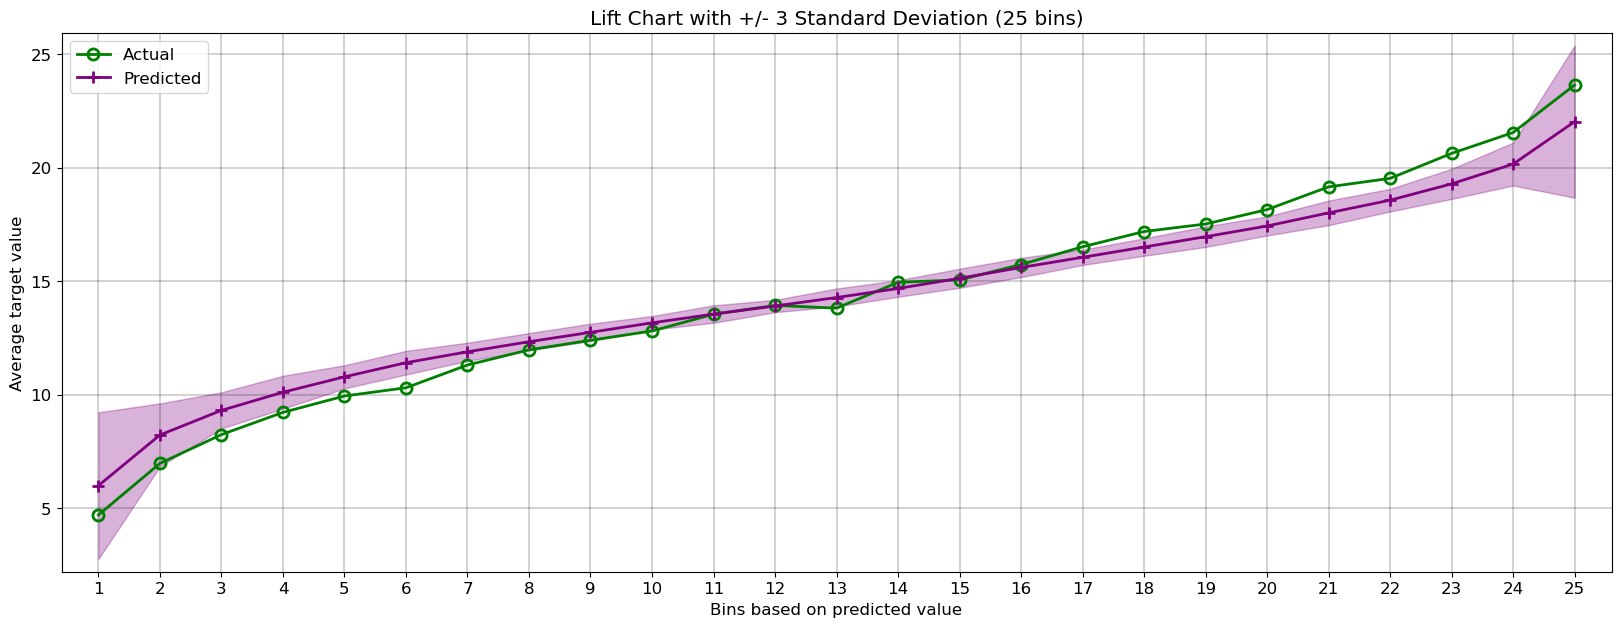

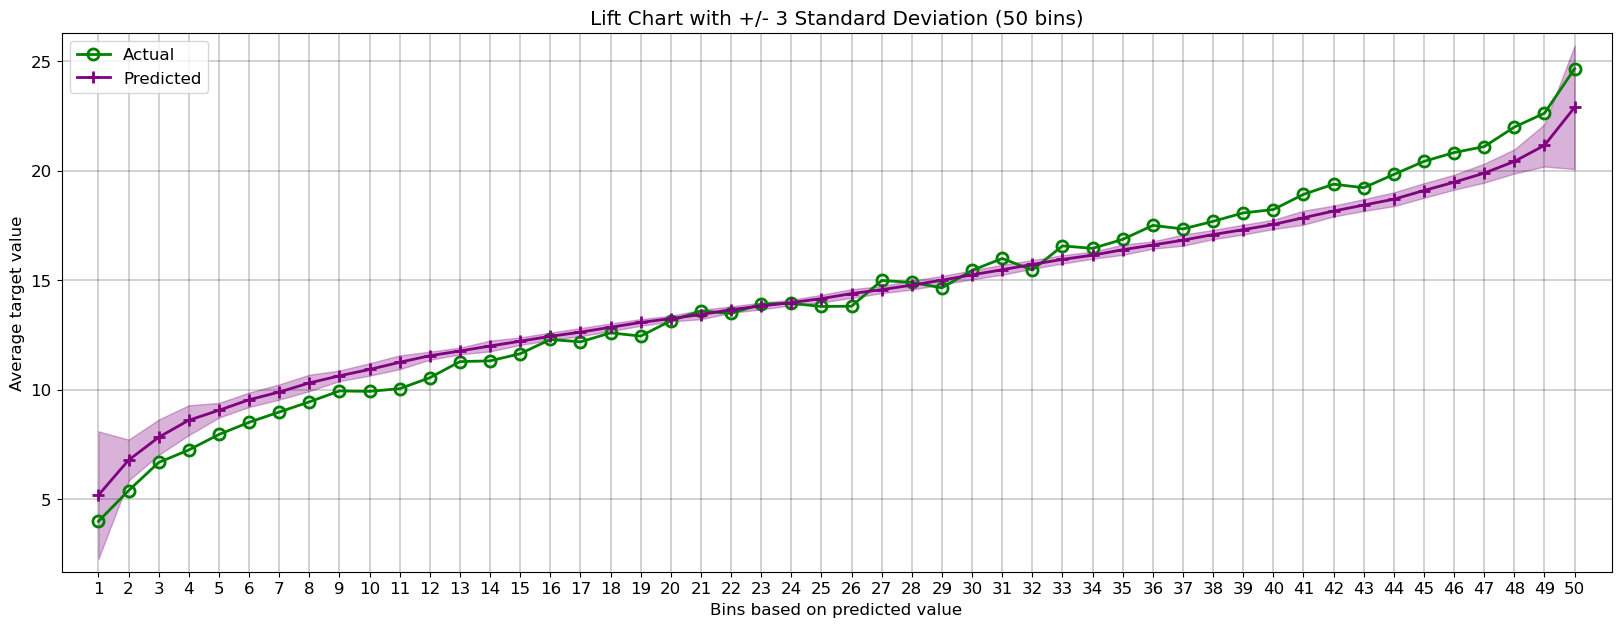

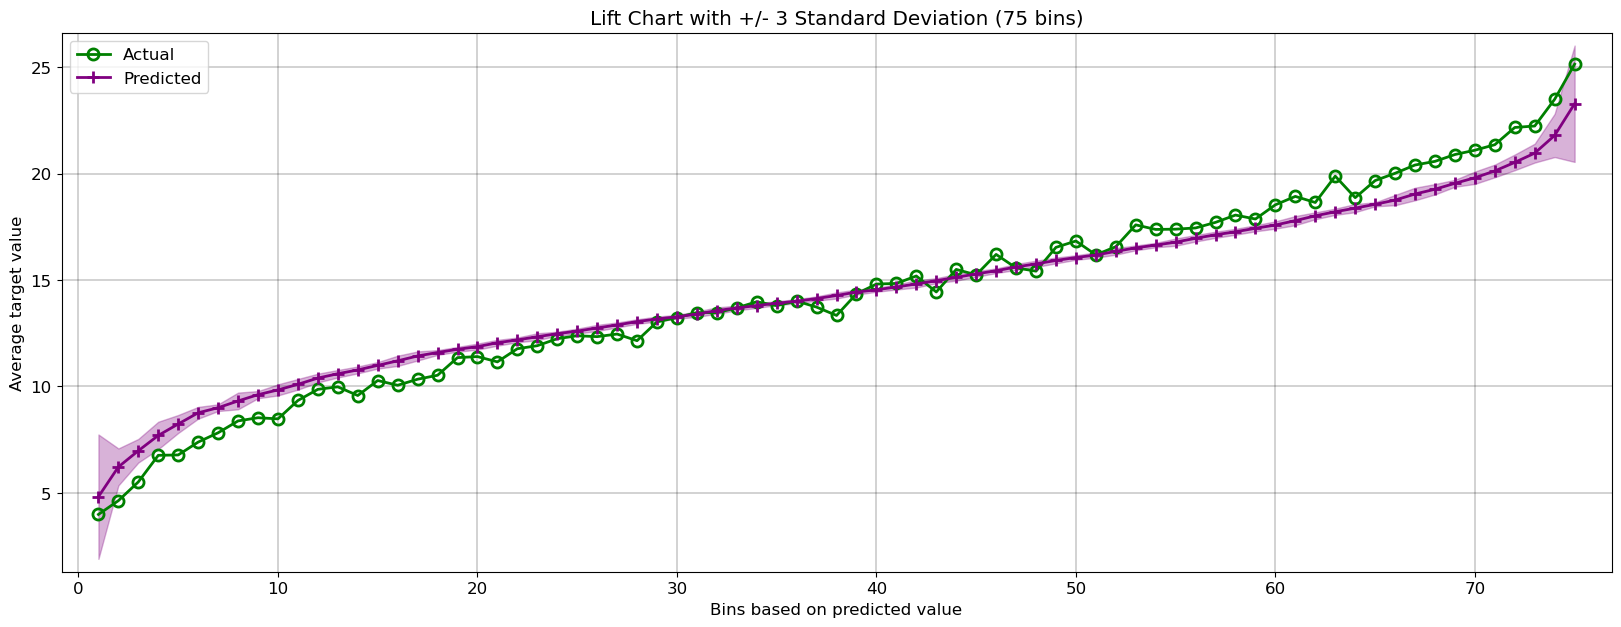

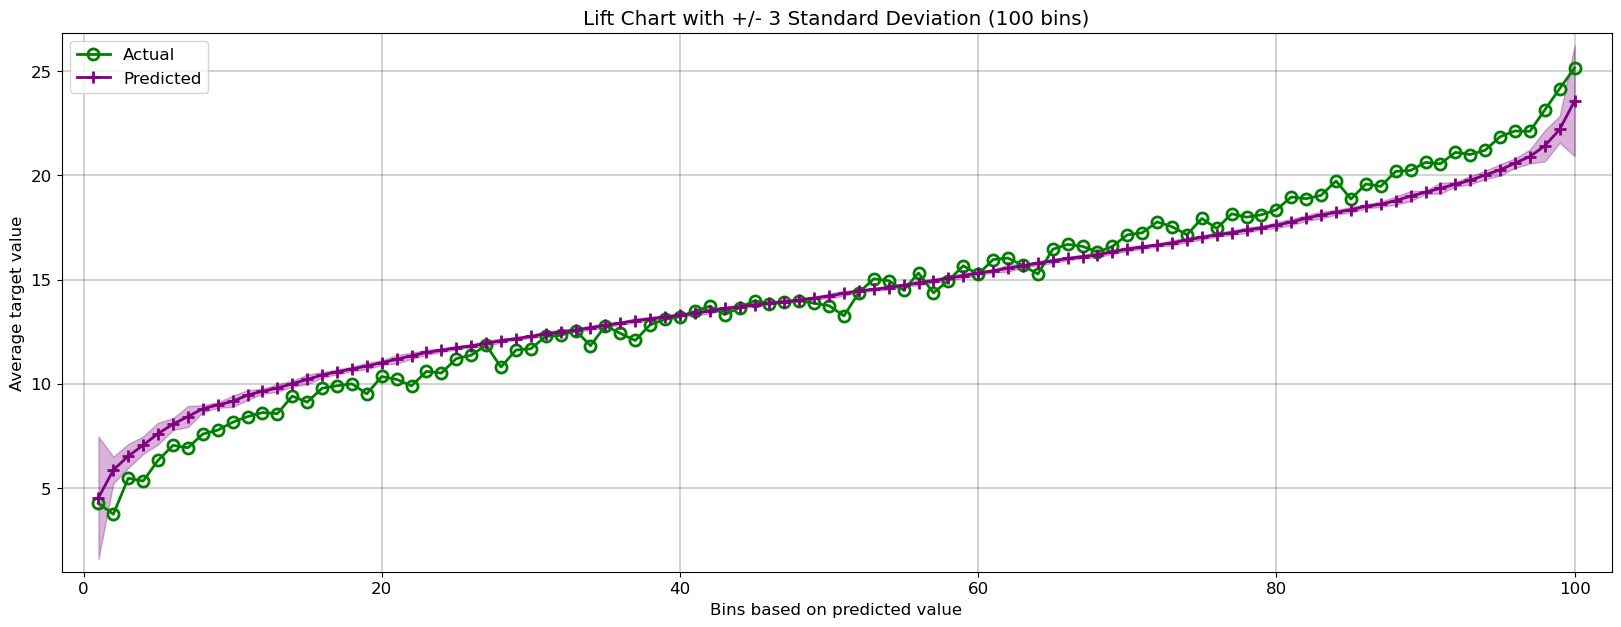

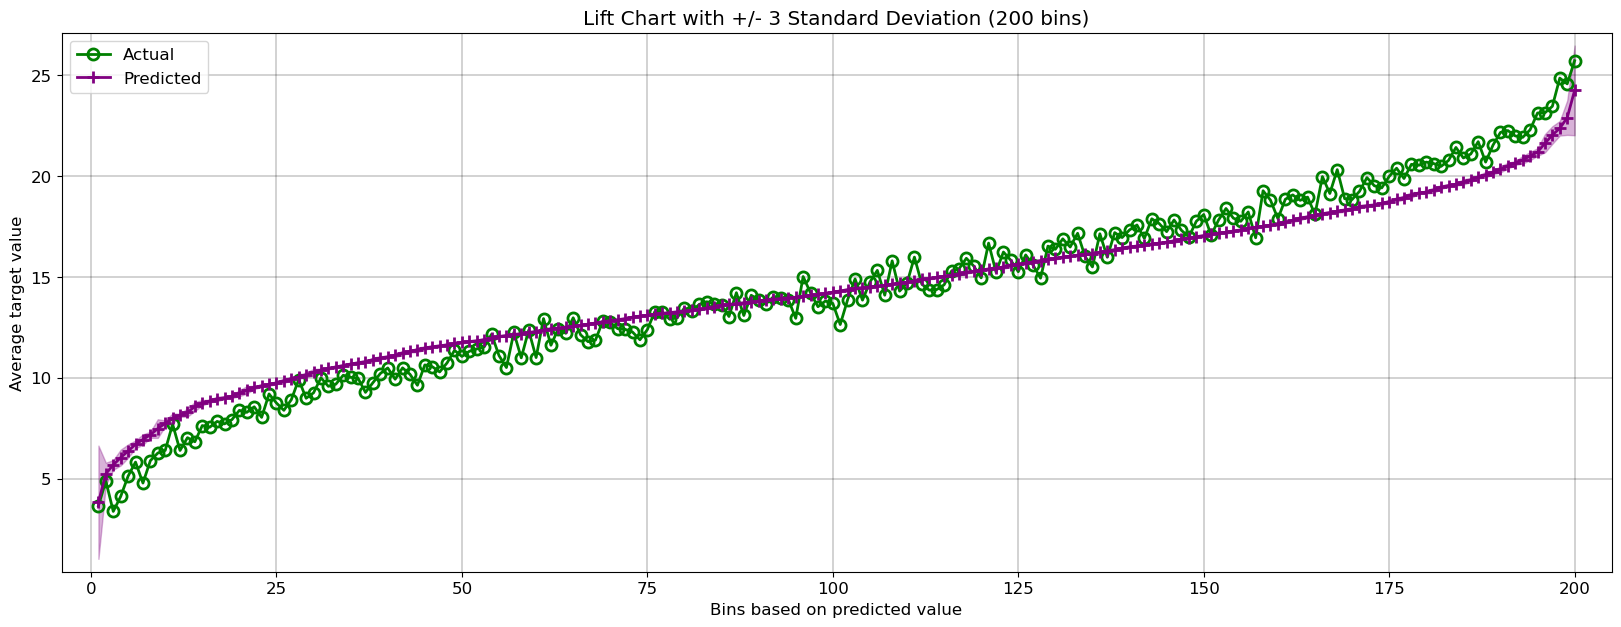

In [18]:
# Now with varying bin sizes with a larger standard deviation multiplier
for bins in [10, 25, 50, 75, 100, 200]:

    # Prep and plot
    lift_chart_data = prepare_lift_chart_data(
        preds=holdout_preds_with_actuals, n_bins=bins
    )
    generate_customized_lift_chart(
        plot_data=lift_chart_data,
        title=f"Lift Chart with +/- 3 Standard Deviation ({bins} bins)",
        std_multiplier=3,
    )